# <center> <font style="color:rgb(100,109,254)">Creating a Panorama  </font> </center>
In this notebook you'll learn how to create to create a Panorama.

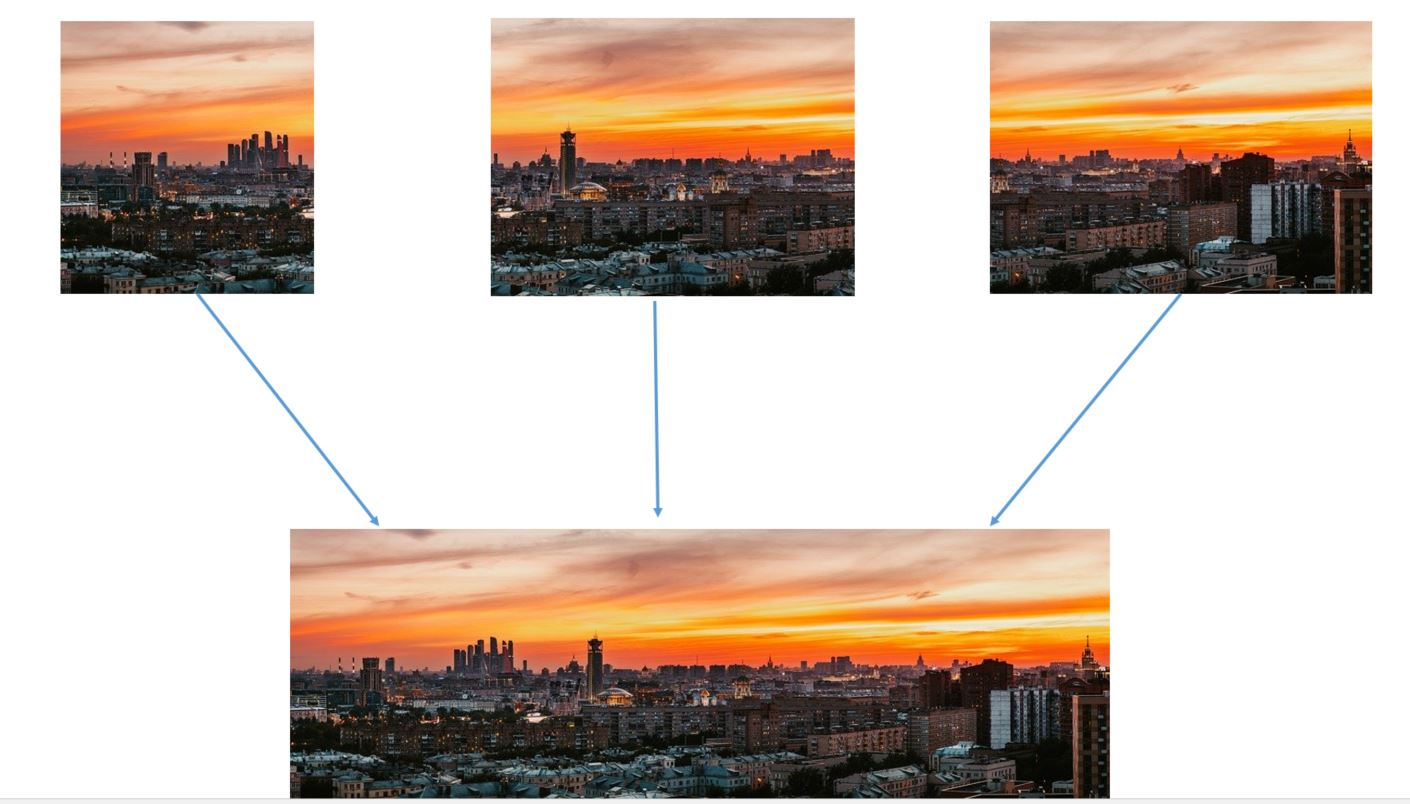


So how does one go about creating a panorama, well creating a good panorama requires a lot of Vision techniques but the basic principle is pretty simple, you first align the images with homography and then stitch them properly that there are no visible outlines or boundaries.

First we'll see how we can create a basic panorama using our implementation, the limitation will be that our implementation will only stitch two images at a time. Then later we'll see how to use the OpenCV stitcher class which will stitch any number of images and will also be a more robust implementation. 

**Note: The Steps for creating a Panorama are identical to that of Image Alignment the difference is that it just has an extra 5th step.**

- **Step 1:** Extract Keypoints and descriptors of both images, img1 and img2.
- **Step 2:** Perform feature matching, select top few matches.
- **Step 3:** Grab the keypoints of the good matches and get a homography of it.
- **Step 4:** Use the homography to transform the image using **warpPerspective** function such that img2 is aligned with img1, and the final width is the sum of img1 and img2.
- **Step 5:** Override pixels of the Aligned Image with img1.

If you think Panorama's are not that interesting then take a look at these [hilarious & disturbing Images](https://mashable.com/2013/05/19/panoramic-photo-fails/) resulting from messed up panoramas.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

## <font style="color:rgb(134,19,348)"> Step 1: Feature Extraction   </font>

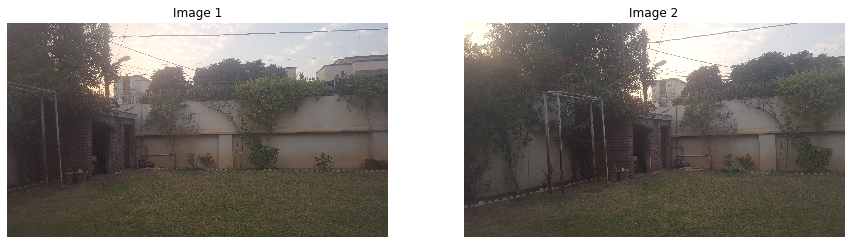

In [154]:
img1 = cv2.imread('media/M4/Panoramas/img2.jpg',1) 
img2 = cv2.imread('media/M4/Panoramas/img3.jpg',1)  

# Initialize ORB detector with features detection limited to 1000 features.
orb = cv2.ORB_create(5000)

# Find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)


plt.figure(figsize=[15,15])
plt.subplot(121);plt.imshow(img1[...,::-1]);plt.title("Image 1");plt.axis('off');
plt.subplot(122);plt.imshow(img2[...,::-1]);plt.title("Image 2");plt.axis('off');

## <font style="color:rgb(134,19,348)"> Step 2: Feature Matching   </font>

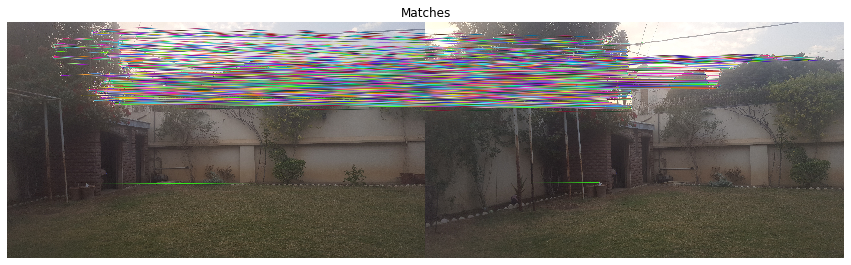

In [163]:
# create bf matcher wiht crosscheck = True
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True) 
matches = bf.match(des1, des2) 
  
# Sort matches on bases of good they are, (i.e on their hamming distance)
matches.sort(key = lambda x: x.distance) 
  
# Contols what percent of top matches you want to consider.
match_percent = 0.45    

# Consider the top 25% matches only. 
good_matches = matches[:int(len(matches)*match_percent)] 

# Display the matches just for visulatization.
matches_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)

plt.figure(figsize=[15,15])
plt.imshow(matches_img[...,::-1]);plt.title("Matches");plt.axis('off');

## <font style="color:rgb(134,19,348)"> Step 3: Homography   </font>

In [164]:
# Getting the x,y Coordinates of the best matches in the right format.
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Get Homography
homo_matrix, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)    

print("Homograhy matrix \n\n {}".format(homo_matrix))

Homograhy matrix 

 [[ 6.22019379e-01  6.49803964e-02  8.56695822e+02]
 [-1.29978929e-01  8.81238070e-01  1.67326349e+02]
 [-1.19503501e-04  3.69828045e-05  1.00000000e+00]]


## <font style="color:rgb(134,19,348)"> Step 4: Align Img2 with Img1.   </font>
Now we will use **warpPerspective()** to perform perspective transformation to align img2 with img1, now here we don't want the output size to be that of  the original image since we are going to be stitching two images horizontally we need the output width to be the sum of width of both images, this way we can paste **img1** on the aligned_img. 


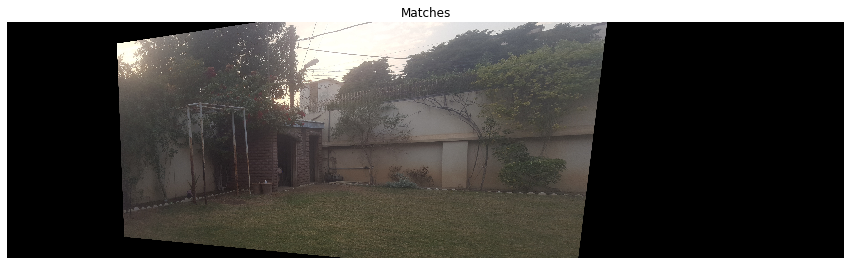

In [165]:
# Get the height and width of the first image.
h1, w1 = img1.shape[:2]

# Get the height and width of the second image.
h2, w2 = img2.shape[:2]

aligned_img = cv2.warpPerspective(img2, homo_matrix, (w1+w2, h2))

plt.figure(figsize=[15,15])
plt.imshow(aligned_img[...,::-1]);plt.title("Matches");plt.axis('off');

## <font style="color:rgb(134,19,348)"> Step 5: Stitch the Image   </font>
Now that img2 is aligned with img1 we can just superimpose img1 on top of aligned_img.

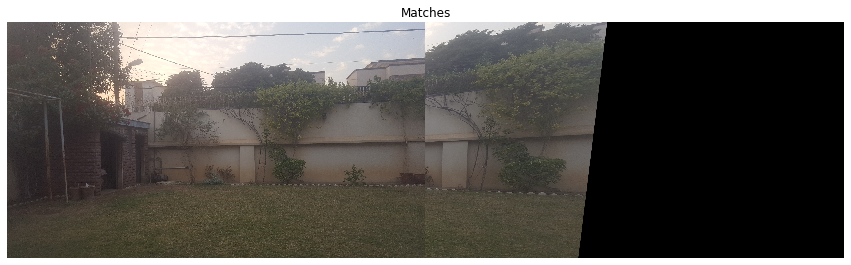

In [166]:
# Stitching image 1 with image 2
stitched = aligned_img.copy()
stitched[0:h1,0:w1] = img1
plt.figure(figsize=[15,15])
plt.imshow(stitched[...,::-1]);plt.title("Matches");plt.axis('off');

**Now there are some issues with this approach.**

You might see some visible outlines at the boundary of the two images. This is mostly because of focus, illumination, exposure changes between frames. This also handles only two images at a time. I could have gotten better results if I had taken these images more carefully.

# <font style="color:rgb(134,19,348)">Panorama Creation with Stitcher Class in OpenCV    </font>
Lets take a look at a more robust approach to panorama stitching using OpenCV stitcher class by using the function `stitcher.stitch()` which uses lots of functions to improve quality and give excellent panoramas. It also works on multiple images.

[```stitcher = cv2.Stitcher_create([, mode])```](https://docs.opencv.org/master/d2/d8d/classcv_1_1Stitcher.html)

- **mode**	Scenario for stitcher operation. This is usually determined by source of images to stitch and their transformation. Default parameters will be chosen for operation in given scenario.

**After creating the stitcher class you will call the stitch method to finally stitch all images.**

[```retval, pano	= cv2.Stitcher.stitch(images, masks[, pano])```](https://docs.opencv.org/master/d2/d8d/classcv_1_1Stitcher.html#a3156a44286a7065ba9e8802023ad2074)

**Params:**
- **`images`**  Input images.
- **`masks`**	Masks for each input image specifying where to look for keypoints (optional).
- **`pano`**	Final pano.


The whole internal pipeline implemented in the stitching class can be seen below:

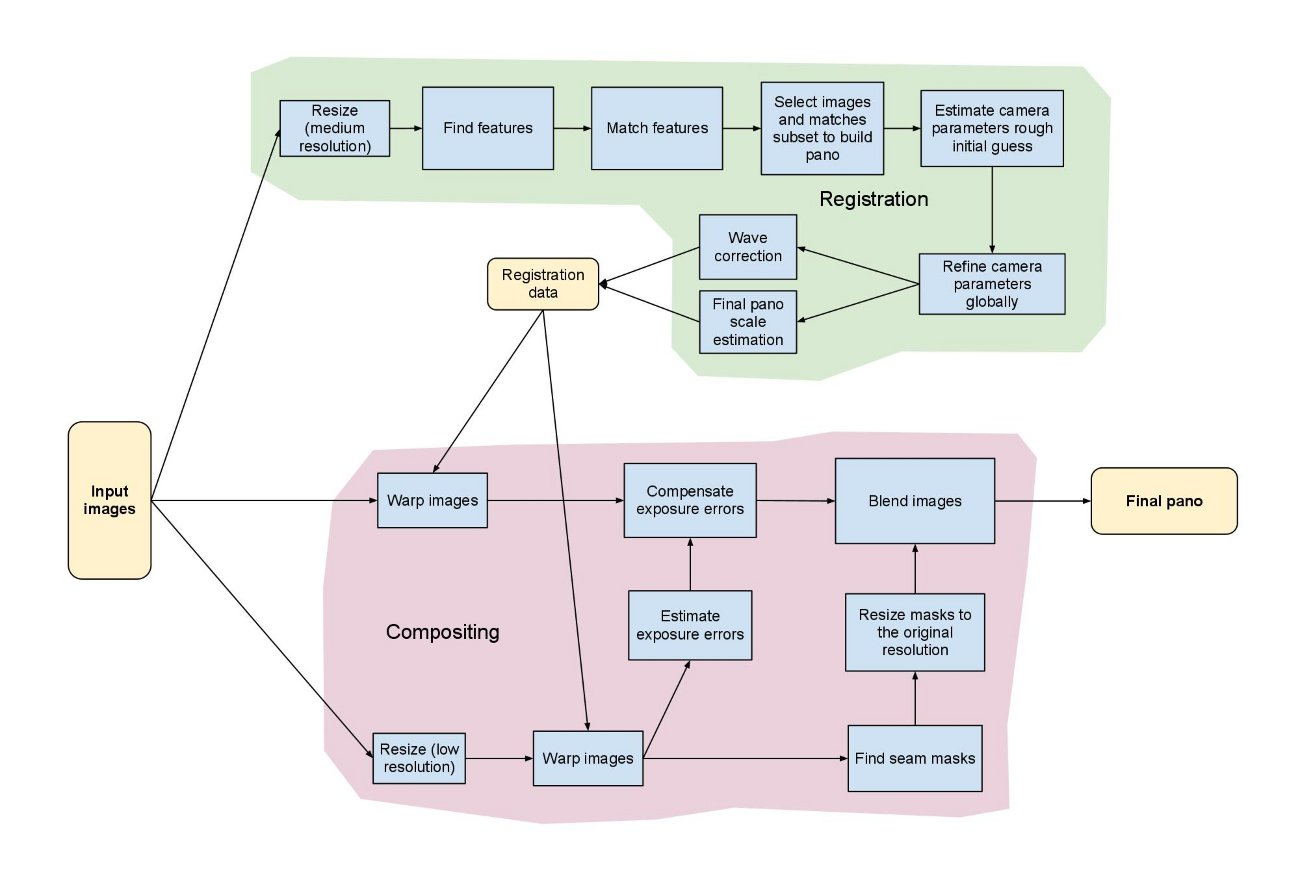

**Load All the Images of the Panorama in a list**

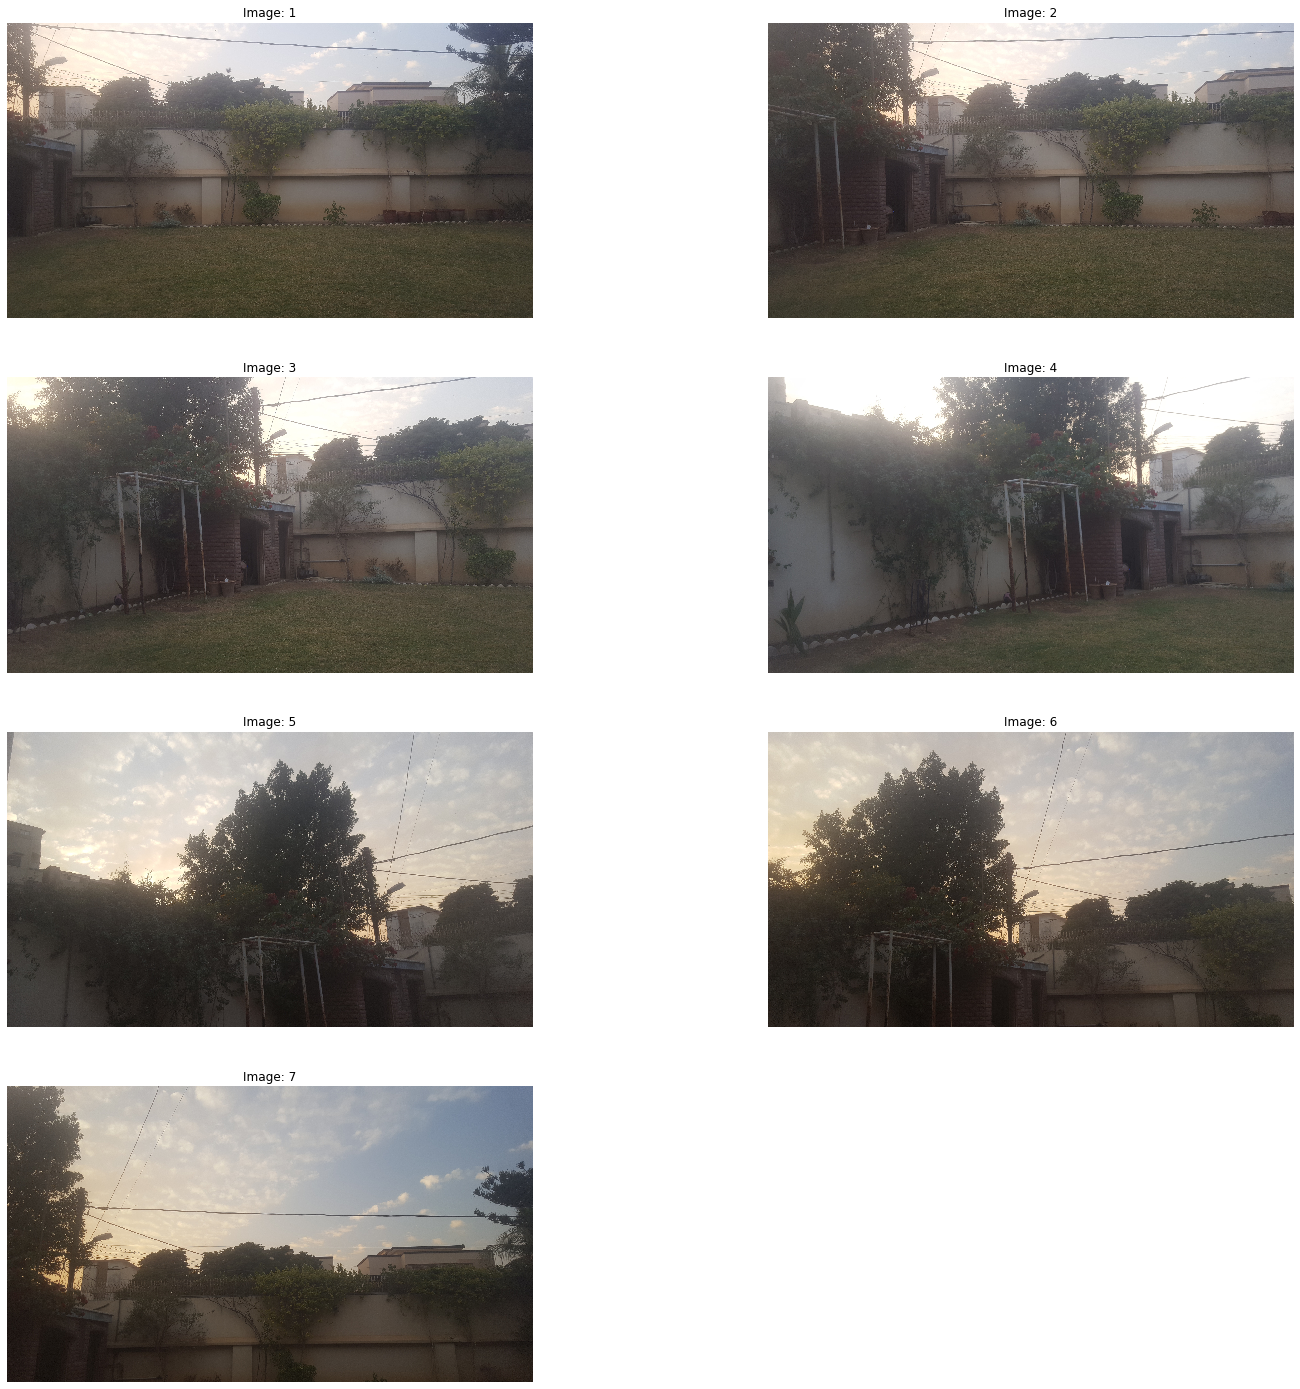

In [95]:
# Get a list of all the image names in the Panorama ifolder.
imagefiles = os.listdir('media/M4/panoramas')

images = []

plt.figure(figsize=[25,25])

rows = np.ceil(len(imagefiles)/2)

# Read & Store all the images in a list. Also plot the images
for filename in imagefiles:
    img = cv2.imread(os.path.join('media/M4/Panoramas', filename))
    images.append(img)
    plt.subplot(rows,2,len(images));plt.imshow(img[...,::-1]);plt.title("Image: {}".format(len(images)));plt.axis('off');

**Generate the Panorama**

In [85]:
# Create the Stitcher Class
stitcher = cv2.Stitcher.create()

# Call the stitch method.
(status, result) = stitcher.stitch(images)

# Not required, you can check if the panorama generation was successful or Not.
if (status == cv2.Stitcher_OK):
    print("Panorama generated Successfully")
else:
    print("Error: {}".format(status))

Panorama generated Successfully


**Lets See our Final Panorama**

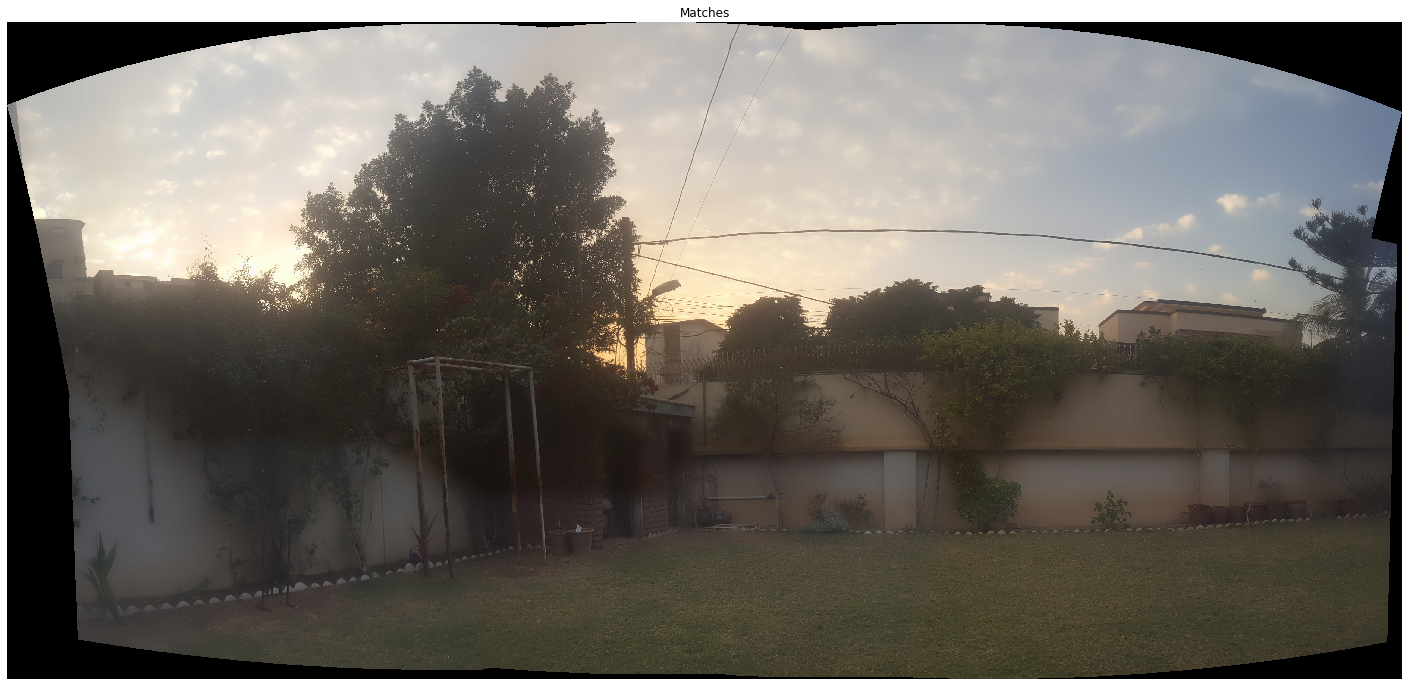

In [87]:
cv2.imwrite('media/M4/panorama.jpg', result)
plt.figure(figsize=[25,25])
plt.imshow(result[...,::-1]);plt.title("Matches");plt.axis('off');

**View the full resolution version on disk**